# Importing Libraries

In [1]:
# !pip install --upgrade librosa

In [1]:
# from google.colab import drive
import zipfile
import os
import librosa
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader,random_split
from torch.nn.utils.rnn import pad_sequence
import random
from librosa.effects import pitch_shift as librosa_pitch_shift
from librosa.effects import time_stretch as librosa_time_stretch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

if torch.cuda.is_available():
    device = torch.device("cuda")  # Set device to GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Idea

This is the basic idea:
1) We load the .wav file using librosa.
2) Use Mel Spectrogram
3) Convert the Spectrogram array to a tensor.
4) Do it for all .wav files using a class Dataloader
5) Build an GRU and train it using the Dataloader
6) Test and finetune.

# Data Augmentation Functions

In [2]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def apply_time_stretch(y, rate=1.0):
    if rate == 1.0:
        return y
    return librosa_time_stretch(y.astype(np.float32), rate=rate)


# Dataset & Dataloader

In [3]:
# Mel-Spectrogram
class CoswaraDataset(Dataset):
    def __init__(self, root_dir, sr=16000, n_mels=40, extensions=(".wav",), augment=False):
        self.root_dir = root_dir
        self.sr = sr
        self.n_mels = n_mels
        self.extensions = extensions
        self.augment = augment

        # Get class folders
        self.classes = sorted(
            entry.name for entry in os.scandir(root_dir) if entry.is_dir()
        )
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Collect all (path, label)
        self.samples = []
        for cls_name in self.classes:
            cls_folder = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(self.extensions):
                    path = os.path.join(cls_folder, fname)
                    self.samples.append((path, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        # Load audio
        y, sr = librosa.load(path, sr=self.sr)

        # Skip empty audio
        if y.size == 0:
            y = np.zeros(1024, dtype=np.float32)

        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=20)

        # Data augmentation
        if self.augment and label == self.class_to_idx['Positive']:
            # Add noise with 30% probability
            if random.random() < 0.3:
                y = add_noise(y)
            # Time stretch with 30% probability
            if random.random() < 0.3:
                y = apply_time_stretch(y, rate=random.uniform(0.9, 1.1))

        # Compute log-Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels,n_fft=min(1024,len(y)))
        log_mel_spec = librosa.power_to_db(mel_spec)  # (n_mels, time)
        log_mel_spec = log_mel_spec.T                # (time, n_mels)

        # Compute delta and delta-delta features
        delta = librosa.feature.delta(log_mel_spec, order=1)   # first derivative
        delta2 = librosa.feature.delta(log_mel_spec, order=2)  # second derivative

        # Concatenate original + delta + delta-delta
        log_mel_spec = np.concatenate([log_mel_spec, delta, delta2], axis=1)  # (time, n_mels*3)

        # Normalize per feature
        log_mel_spec = (log_mel_spec - np.mean(log_mel_spec, axis=0)) / \
                       (np.std(log_mel_spec, axis=0) + 1e-9)

        # Convert to torch tensors
        x = torch.tensor(log_mel_spec, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.long)

        return x, y


In [4]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs_padded = pad_sequence(xs, batch_first=True)  # shape: (batch, max_time, feature_dim)
    ys = torch.stack(ys)
    return xs_padded, ys

In [5]:
full_dataset = CoswaraDataset('Voice_b',n_mels=30, augment=True)

In [6]:
generator1 = torch.Generator().manual_seed(42)

In [7]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size],generator=generator1)

In [8]:
full_dataset.classes

['Negative', 'Positive']

In [9]:
train_dataloader = DataLoader(train_dataset,batch_size = 32,shuffle=True,collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False,collate_fn=collate_fn)

# Model

In [10]:
import torch
import torch.nn as nn

class CovidGRU(nn.Module):
    def __init__(self, input_dim=120, hidden_dim=128, num_layers=1, fc_dim=64, 
                 num_classes=2, dropout=0.4, bidirectional=False):
        super().__init__()

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        gru_out_dim = hidden_dim * (2 if bidirectional else 1)

        self.fc1 = nn.Linear(gru_out_dim, fc_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x):
        # x: (batch, time, feature_dim)
        out, _ = self.gru(x)  # out: (batch, time, hidden_dim)

        # Mask to ignore zero-padded frames
        mask = (x.abs().sum(dim=-1) != 0).float()  # (batch, time)

        # Compute effective lengths to avoid divide-by-zero
        lengths = mask.sum(dim=1, keepdim=True).clamp(min=1e-6)

        # Weighted mean pooling
        pooled = (out * mask.unsqueeze(-1)).sum(dim=1) / lengths  # (batch, hidden_dim)

        # Fully connected classifier
        x = self.fc1(pooled)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits


In [11]:
in_dim = full_dataset[0][0].shape[1]
num_layers = 2

In [12]:
model  = CovidGRU(input_dim=in_dim,num_layers=num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [13]:
model = model.to(device)

# Training

In [14]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10, patience=3):
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # --- Training loop ---
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')

        # --- Validation loop ---
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(test_dataset)
        val_acc = val_corrects.double() / len(test_dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # --- Step scheduler ---
        if scheduler is not None:
            scheduler.step(val_loss)

        # --- Early stopping based on accuracy ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_wts = model.state_dict().copy()
            print(f'Validation accuracy improved. Saving model...')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered at epoch {epoch+1}.')
                model.load_state_dict(best_model_wts)
                break

    print('\nTraining complete.')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')
    return model


In [15]:
train_model(model, criterion, optimizer, num_epochs=20,scheduler=scheduler,patience=5)

C:\Users\david\anaconda3\envs\MOSMED\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
C:\Users\david\anaconda3\envs\MOSMED\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1366
  warnings.warn(



Epoch 1/20
Train Loss: 0.6291, Train Acc: 0.7017
Val Loss: 0.5875, Val Acc: 0.7137
Validation accuracy improved. Saving model...

Epoch 2/20
Train Loss: 0.5933, Train Acc: 0.7066
Val Loss: 0.5794, Val Acc: 0.7180
Validation accuracy improved. Saving model...

Epoch 3/20
Train Loss: 0.5718, Train Acc: 0.7251
Val Loss: 0.5591, Val Acc: 0.7332
Validation accuracy improved. Saving model...

Epoch 4/20
Train Loss: 0.5500, Train Acc: 0.7381
Val Loss: 0.5279, Val Acc: 0.7570
Validation accuracy improved. Saving model...

Epoch 5/20
Train Loss: 0.5246, Train Acc: 0.7592
Val Loss: 0.5146, Val Acc: 0.7614
Validation accuracy improved. Saving model...

Epoch 6/20
Train Loss: 0.4920, Train Acc: 0.7690
Val Loss: 0.5187, Val Acc: 0.7636
Validation accuracy improved. Saving model...

Epoch 7/20
Train Loss: 0.4766, Train Acc: 0.7885
Val Loss: 0.5217, Val Acc: 0.7701
Validation accuracy improved. Saving model...

Epoch 8/20
Train Loss: 0.4548, Train Acc: 0.7972
Val Loss: 0.5360, Val Acc: 0.7679

Epoch

CovidGRU(
  (gru): GRU(90, 128, num_layers=2, batch_first=True, dropout=0.4)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

# Saving Model

In [16]:
torch.save(model, "gru_cough_b.pth")

# Evaluation

In [22]:
# model = torch.load('gru_cough_b.pth')

## Classification Report

In [17]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [18]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.82      0.84      0.83       329
    Positive       0.57      0.55      0.56       132

    accuracy                           0.75       461
   macro avg       0.70      0.69      0.70       461
weighted avg       0.75      0.75      0.75       461



## Confusion Matrix

In [19]:
cm = confusion_matrix(all_labels, all_preds)

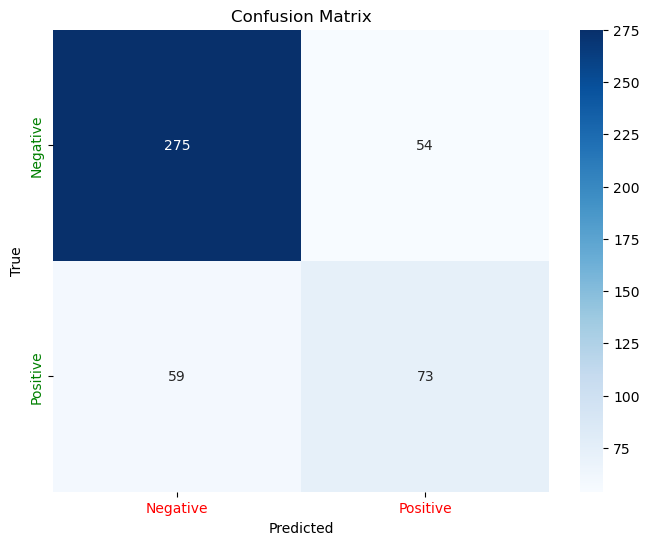

In [21]:
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=full_dataset.classes,
                 yticklabels=full_dataset.classes)

# Set tick label colors
for tick_label in ax.get_xticklabels():
    tick_label.set_color('red')  # X-axis labels in red

for tick_label in ax.get_yticklabels():
    tick_label.set_color('green')  # Y-axis labels in green

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
# plt.savefig("gru_confusion_matrix_b.png", bbox_inches='tight')
plt.show()
